In [92]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas  # noqa

import logging
logging.basicConfig(level=logging.INFO)

In [94]:
from src.parameters import ANIMALS

epoch_key = ('chimi', 5, 2) #animID, day, ep
#epoch_key = ('jaq', 1, 2)

In [95]:
from loren_frank_data_processing.position import _get_pos_dataframe

position_info = _get_pos_dataframe(epoch_key, ANIMALS)

position_info

,x_position,y_position,head_direction,speed
time,,,,
00:39:20.420276,90.334794,211.747777,2.886429,41.448349
00:39:20.453601,90.376906,213.203137,2.520859,33.600350
00:39:20.486947,90.617944,214.320066,2.246627,27.648627
00:39:20.520271,91.016977,215.133521,2.040713,23.829243
00:39:20.553617,91.583483,215.641452,1.876369,22.353405
...,...,...,...,...
01:01:11.528960,182.125415,201.303548,-0.932867,1.029123
01:01:11.562285,182.146361,201.334609,-0.944710,1.082492
01:01:11.595609,182.164424,201.363384,-0.959446,0.987917


In [96]:
#position_info.iloc[:int(np.round(len(position_info)/2))].hvplot.line('x_position', 'y_position', height=500, width=500)
position_info.iloc[int(np.round(len(position_info)/2)):].hvplot.line('x_position', 'y_position', height=500, width=500)

:Curve   [x_position]   (y_position)

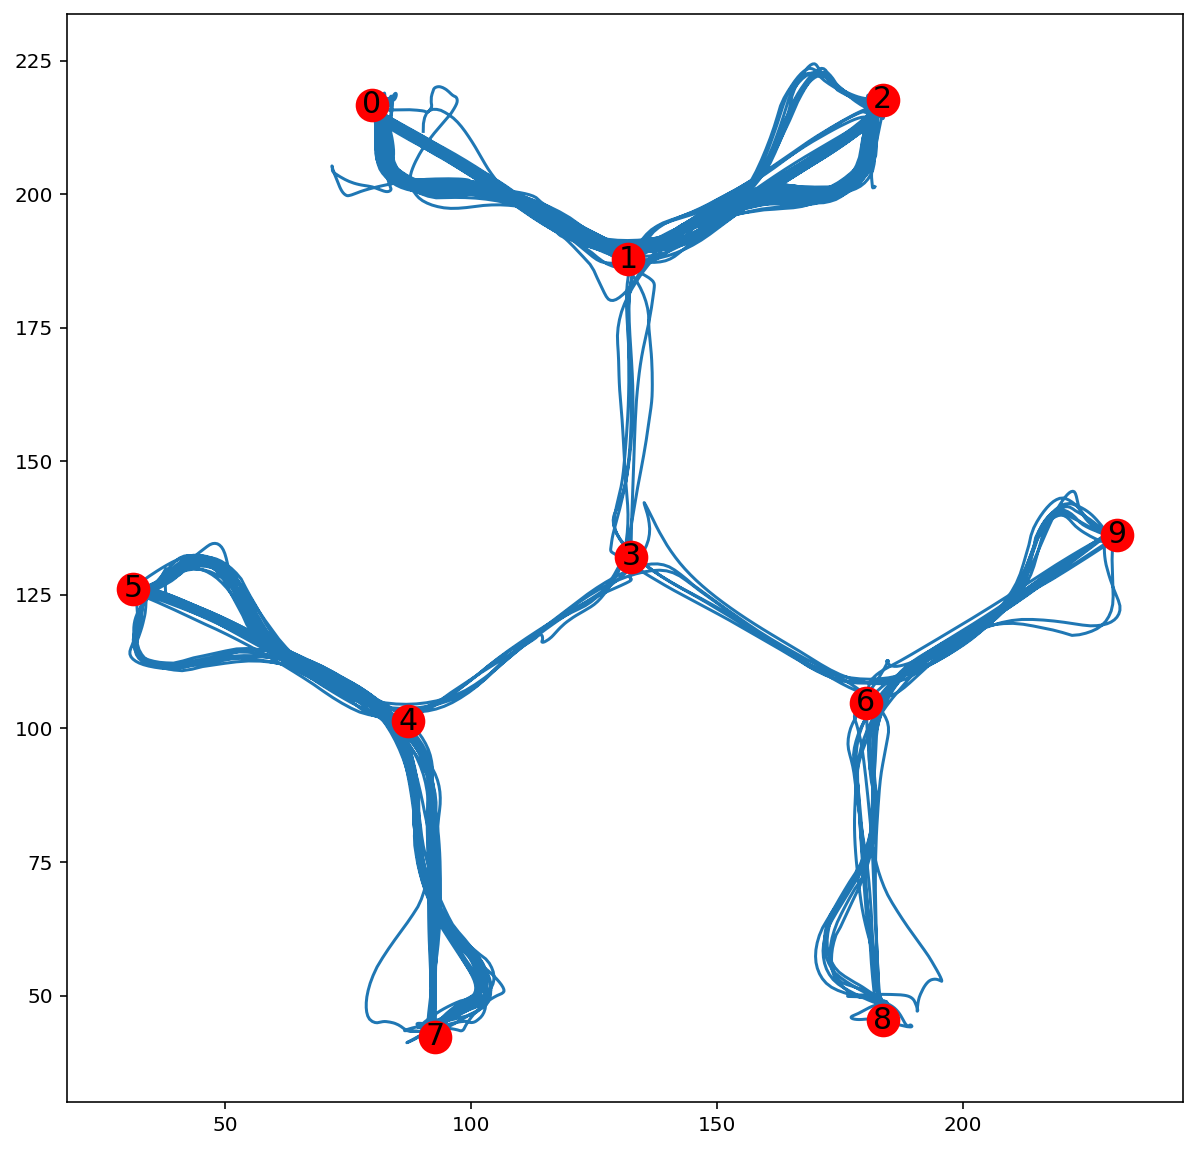

In [97]:
node_positions = np.array([
    (79.910, 216.720), # top left well 0
    (132.031, 187.806), # top middle intersection 1
    (183.718, 217.713), # top right well 2
    (132.544, 132.158), # middle intersection 3
    (87.202, 101.397),  # bottom left intersection 4
    (31.340, 126.110), # middle left well 5 
    (180.337, 104.799), # middle right intersection 6
    (92.693, 42.345),  # bottom left well 7 
    (183.784, 45.375),  # bottom right well 8
    (231.338, 136.281), # middle right well 9
])

# node_positions = np.array([
#     (18.091, 55.053), # top left well 0
#     (33.583, 48.357), # top middle intersection 1
#     (47.753, 56.512), # top right well 2
#     (33.973, 31.406), # middle intersection 3
#     (21.166, 21.631),  # bottom left intersection 4
#     (04.585, 28.966), # middle left well 5 
#     (48.539, 24.572), # middle right intersection 6
#     (22.507, 05.012),  # bottom left well 7 
#     (49.726, 07.439),  # bottom right well 8
#     (62.755, 33.410), # middle right well 9
# ])

edges = np.array([
    (0, 1),
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (3, 6),
    (6, 9),
    (4, 7),
    (6, 8),
])

track_segments = np.array([(node_positions[e1], node_positions[e2]) for e1, e2 in edges])
edge_distances = np.linalg.norm(
    np.diff(track_segments, axis=-2).squeeze(), axis=1)

plt.figure(figsize=(10,10))
plt.plot(position_info.x_position, position_info.y_position)
plt.scatter(node_positions[:, 0], node_positions[:, 1], color='red', zorder=10, s=250)
for i, (x, y) in enumerate(node_positions):
    plt.text(x, y, i, zorder=10, ha='center', va='center', fontsize=15, color='black')

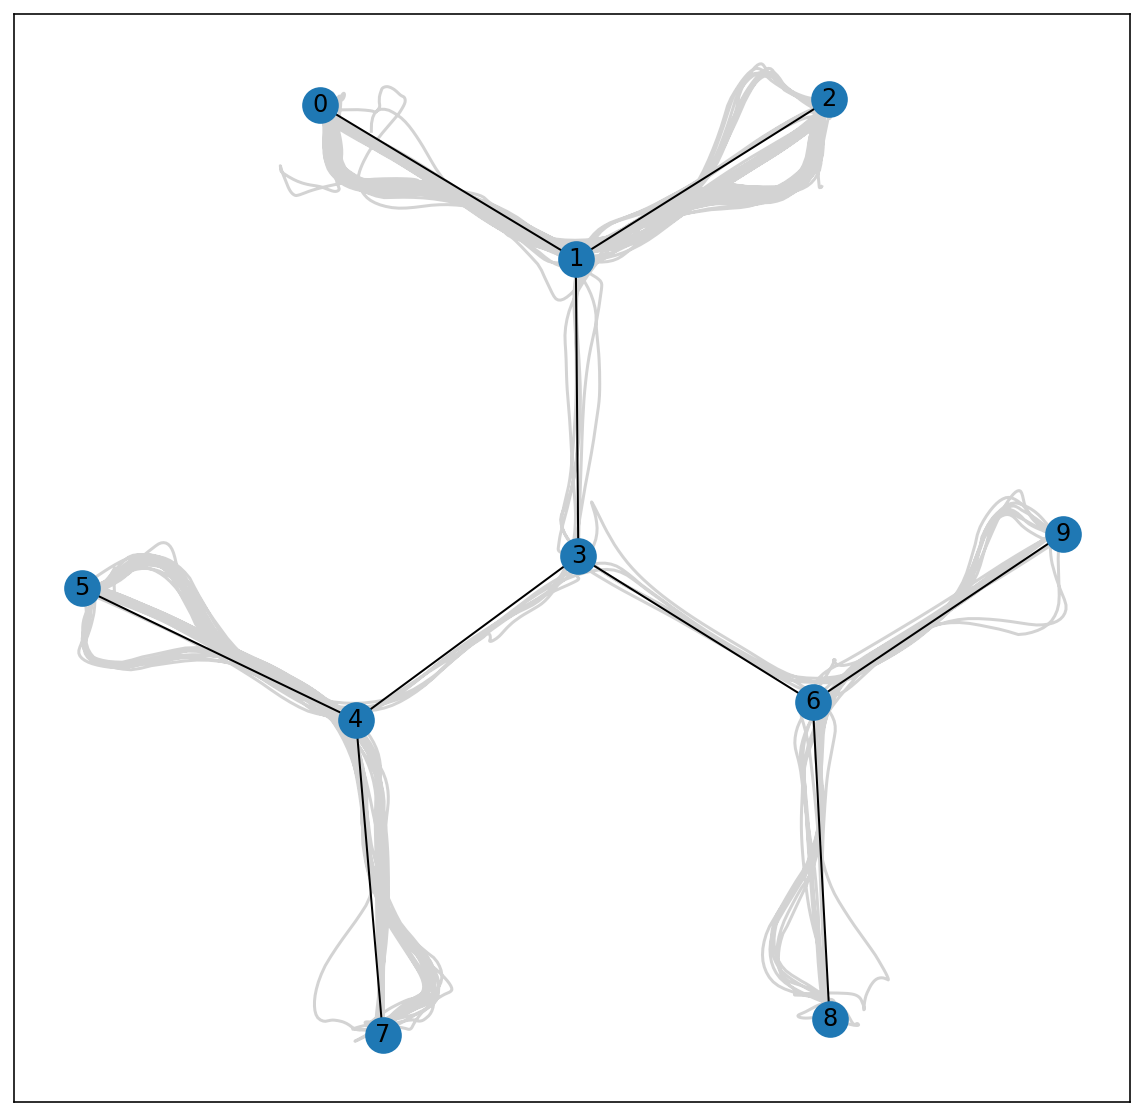

In [98]:
import networkx as nx
from loren_frank_data_processing.track_segment_classification import plot_track

track_graph = nx.Graph()

for node_id, node_position in enumerate(node_positions):
    track_graph.add_node(node_id, pos=tuple(node_position))

for edge, distance in zip(edges, edge_distances):
    nx.add_path(track_graph, edge, distance=distance)

plt.figure(figsize=(10,10))
plt.plot(position_info.x_position, position_info.y_position, color='lightgrey', zorder=-1)    
plot_track(track_graph)

In [99]:
from loren_frank_data_processing.track_segment_classification import classify_track_segments

position = position_info.loc[:, ['x_position', 'y_position']].values

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=0.1,
    sensor_std_dev=10)

In [100]:
position_info['track_segment_id'] = track_segment_id

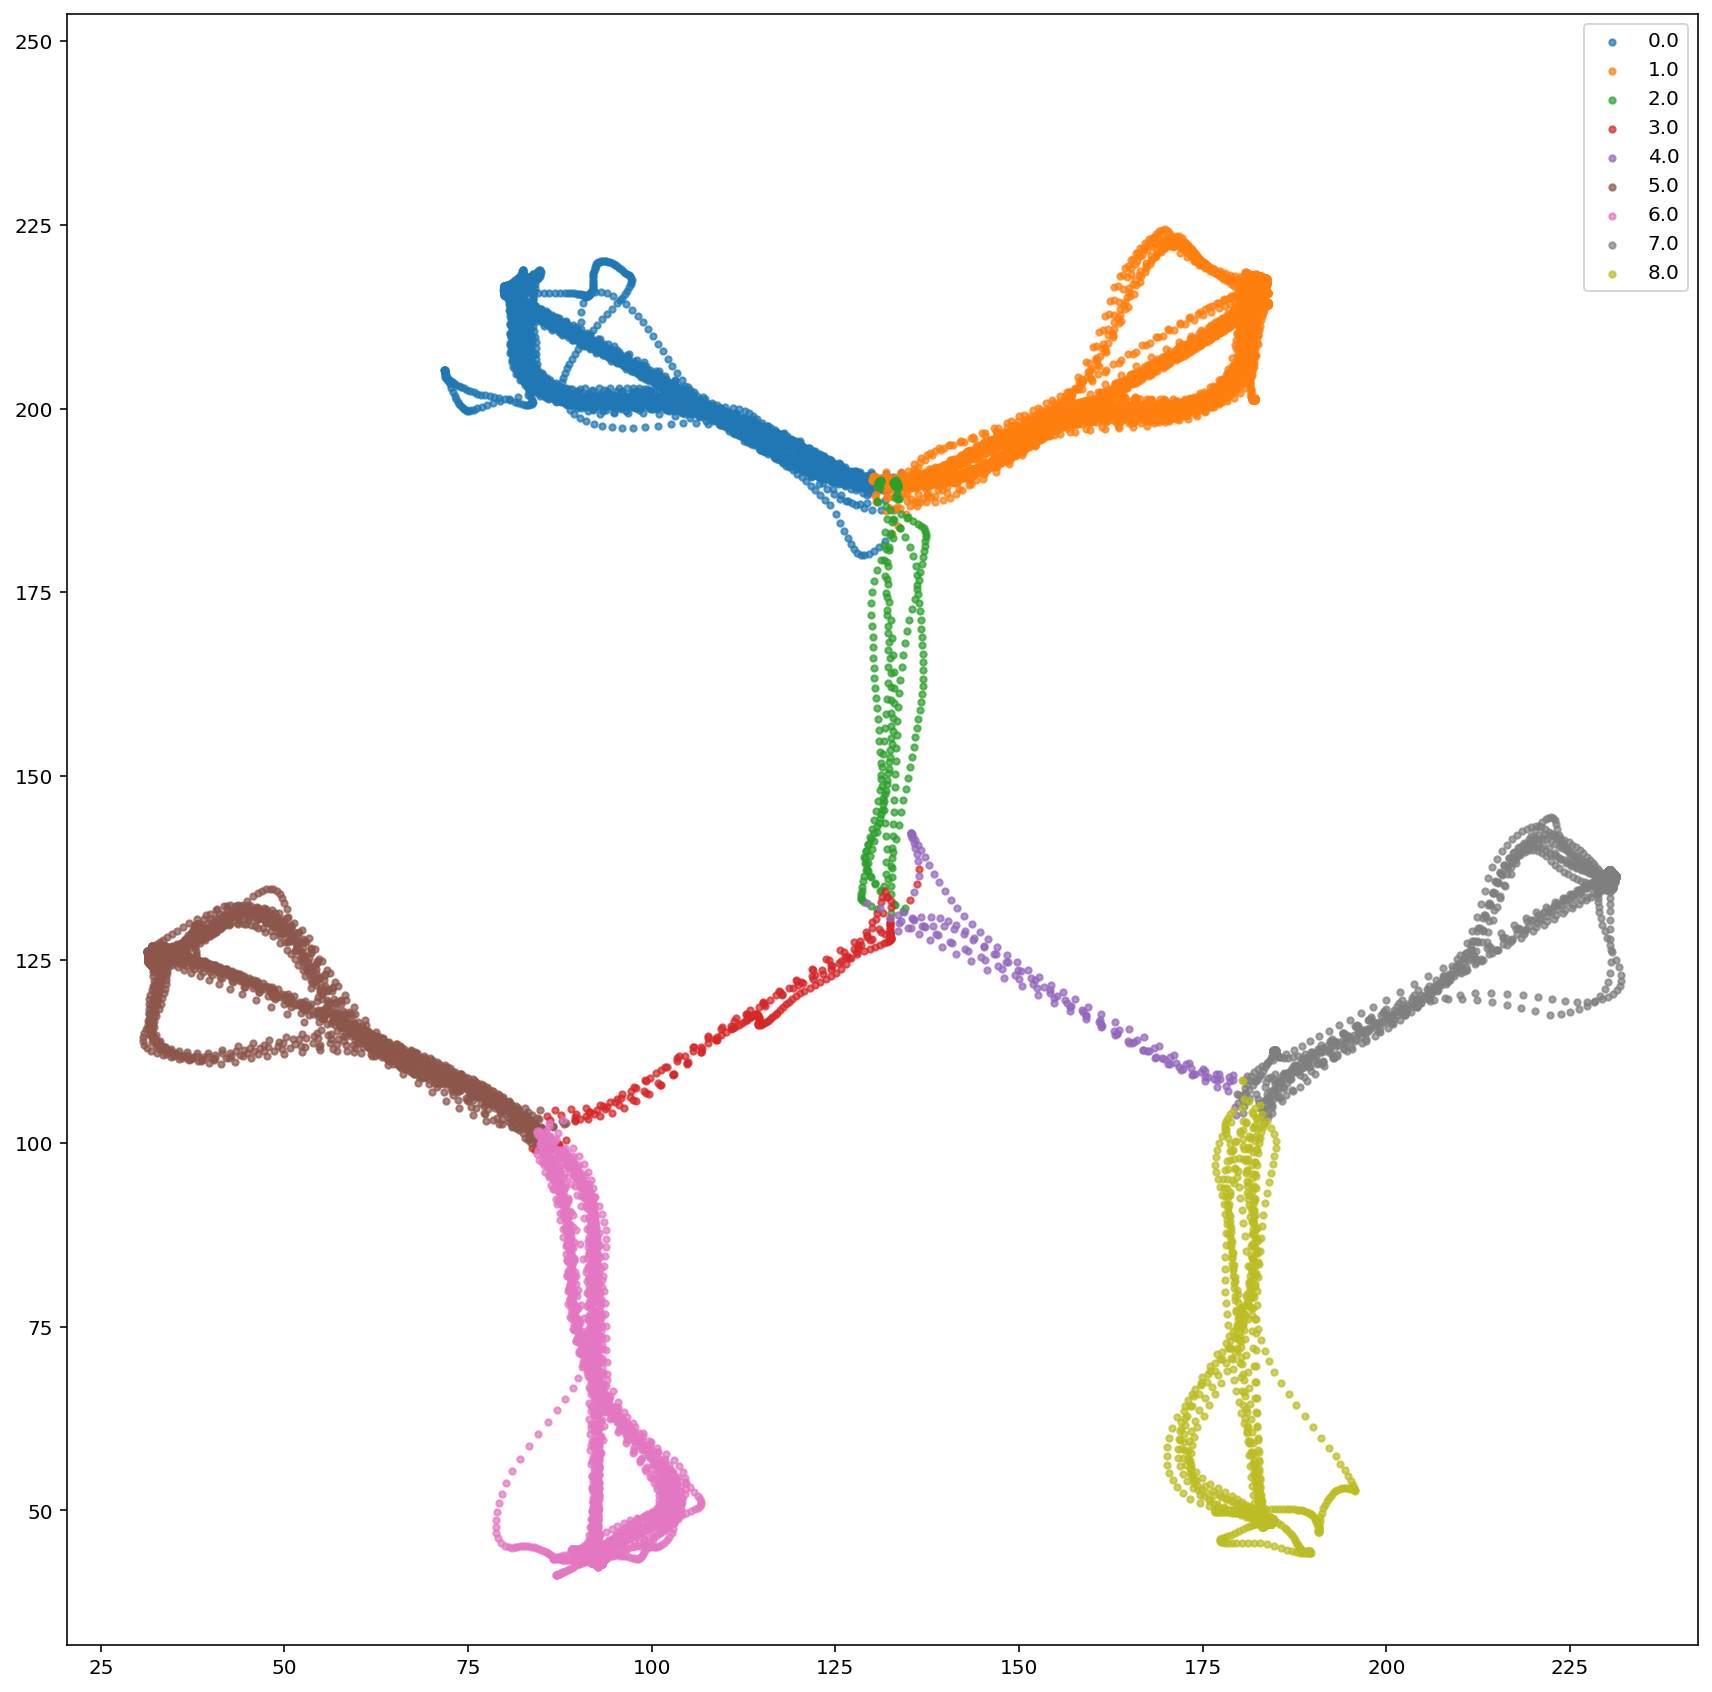

In [101]:
fig, ax = plt.subplots(figsize=(15, 15))

for edge_label, df in position_info.groupby('track_segment_id'):
    ax.scatter(df.x_position, df.y_position, s=10, alpha=0.7, label=edge_label)
plt.legend()
plt.axis('square');

In [102]:
from loren_frank_data_processing.track_segment_classification import calculate_linear_distance

center_well_id = 7

linear_distance = calculate_linear_distance(
    track_graph, track_segment_id, center_well_id, position)

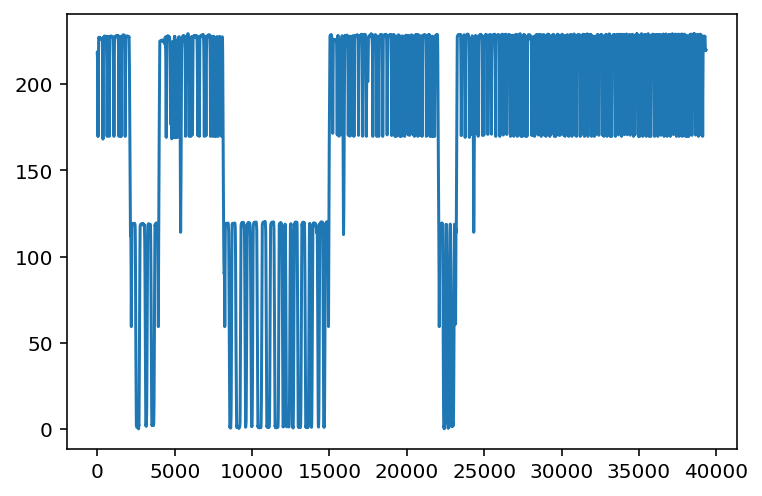

In [103]:
plt.plot(linear_distance[0]) #ED didn't have 0 in there and it still plotted for some reason

In [104]:
linear_position = linear_distance[0].copy() #I also had to fix this here for some reason and add the [0]

linear_edge_order = [6, 5, 3, 8, 7, 4, 2, 0, 1]
spacing = 15

for prev_edge, cur_edge in zip(linear_edge_order[:-1], linear_edge_order[1:]):
    is_cur_edge = (track_segment_id == cur_edge)
    is_prev_edge = (track_segment_id == prev_edge)
    
    cur_distance = linear_position[is_cur_edge]
    cur_distance -= cur_distance.min()
    cur_distance += linear_position[is_prev_edge].max() + spacing
    linear_position[is_cur_edge] = cur_distance
    

In [105]:
position_info['linear_position'] = linear_position

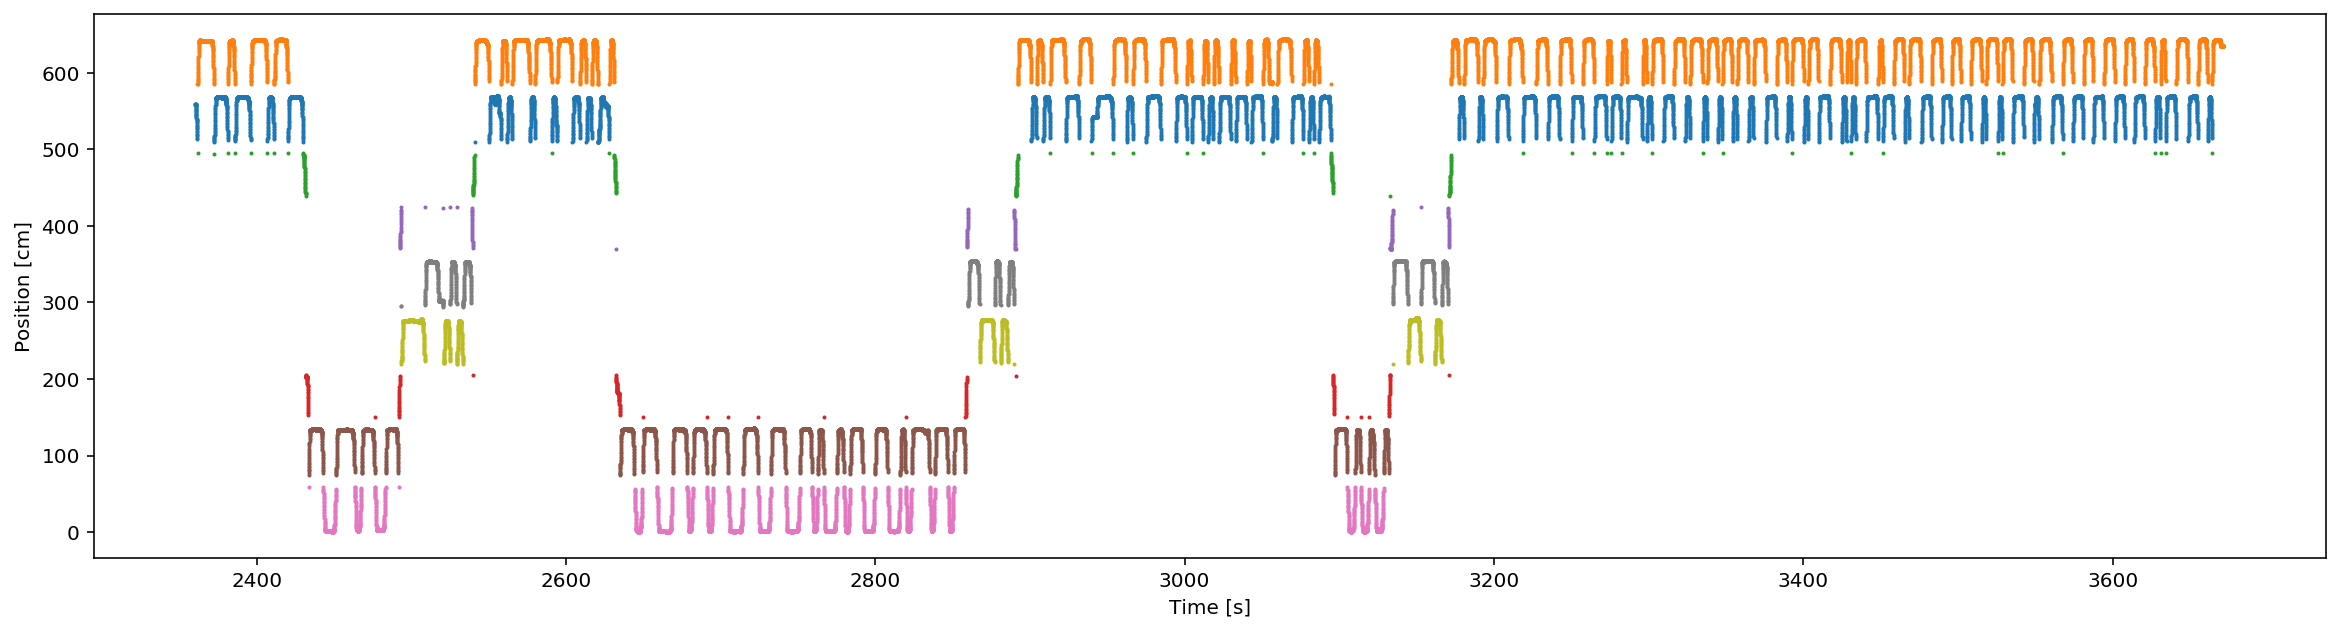

In [106]:
fig, ax = plt.subplots(figsize=(20, 5))

for edge_label, df in position_info.groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

## Compare to interpolated position

In [107]:
from src.load_data import get_interpolated_position_info

p = get_interpolated_position_info(epoch_key, ANIMALS)

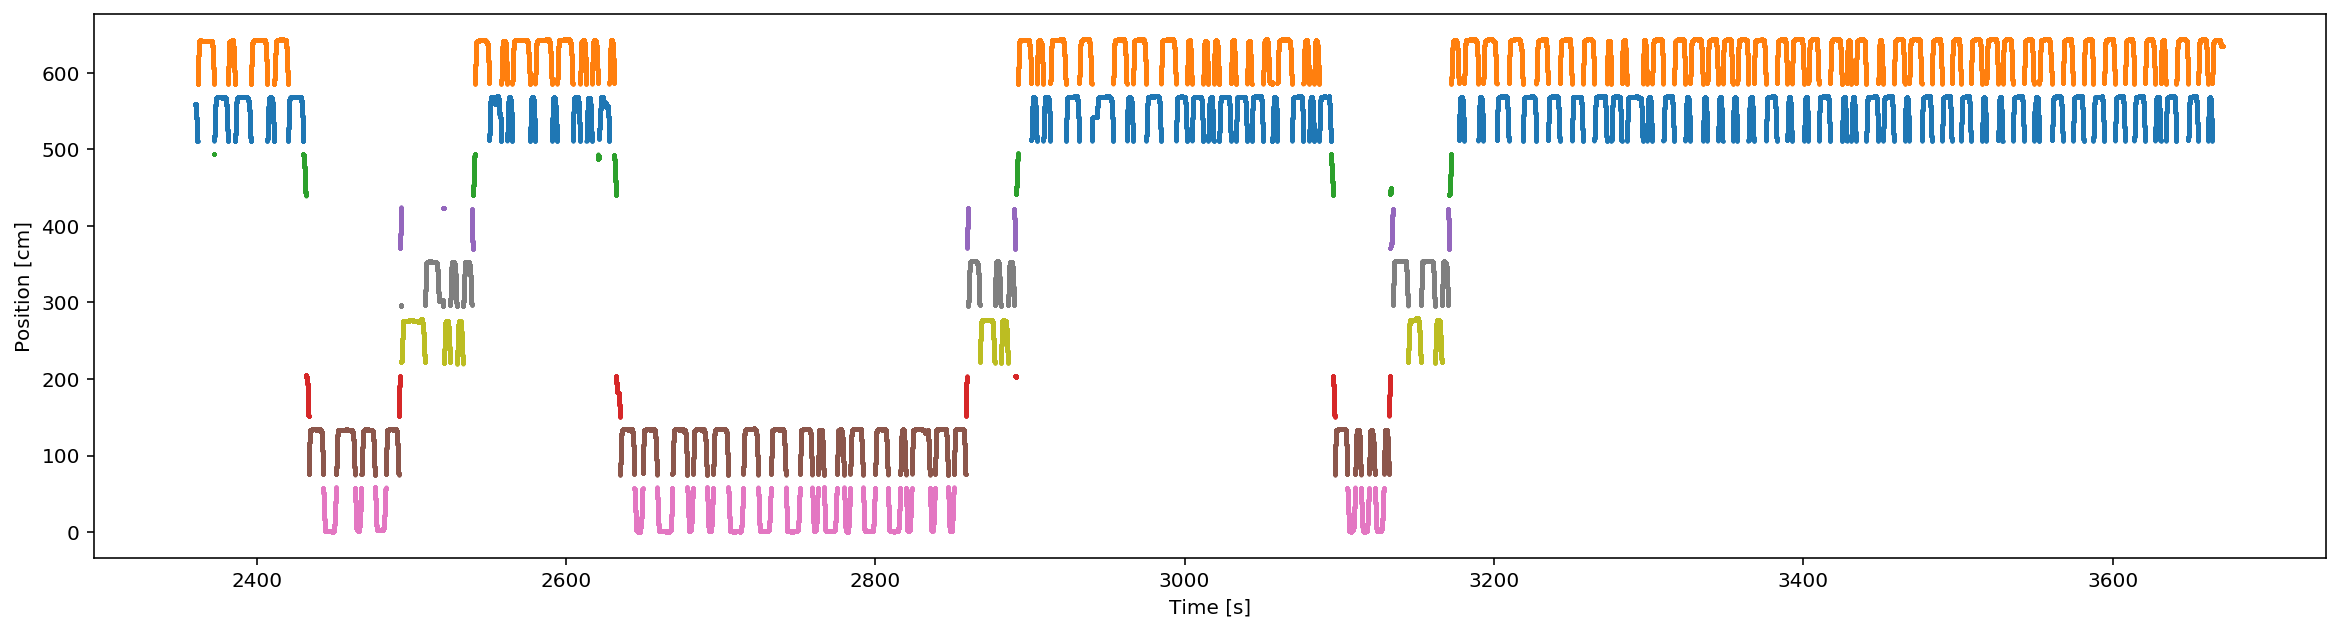

In [108]:
fig, ax = plt.subplots(figsize=(20, 5))

for edge_label, df in p.groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

In [109]:
p

,x_position,y_position,head_direction,speed,linear_distance,projected_x_position,projected_y_position,track_segment_id,linear_position,linear_velocity,linear_speed
time,,,,,,,,,,,
00:39:20.420276,90.334794,211.747777,2.886429,41.448349,217.824627,89.990806,211.127697,0.0,558.437792,-0.101552,0.101552
00:39:20.422276,90.337426,211.838737,2.863581,40.957849,217.866451,89.954233,211.147986,0.0,558.479616,-0.101552,0.101552
00:39:20.424276,90.340058,211.929697,2.840733,40.467349,217.908274,89.917661,211.168274,0.0,558.521439,-0.203100,0.203100
00:39:20.426276,90.342690,212.020657,2.817885,39.976849,217.950098,89.881088,211.188563,0.0,558.563262,-0.304644,0.304644
00:39:20.428276,90.345322,212.111617,2.795037,39.486349,217.991921,89.844515,211.208852,0.0,558.605086,-0.406184,0.406184
...,...,...,...,...,...,...,...,...,...,...,...
01:01:11.654276,182.175781,201.391894,-0.996263,0.578596,219.955799,175.487620,212.950759,1.0,635.172806,0.001682,0.001682
01:01:11.656276,182.175979,201.392460,-0.997717,0.563956,219.956253,175.488014,212.950986,1.0,635.173261,0.001346,0.001346
01:01:11.658276,182.176177,201.393025,-0.999172,0.549316,219.956708,175.488407,212.951214,1.0,635.173715,0.001010,0.001010


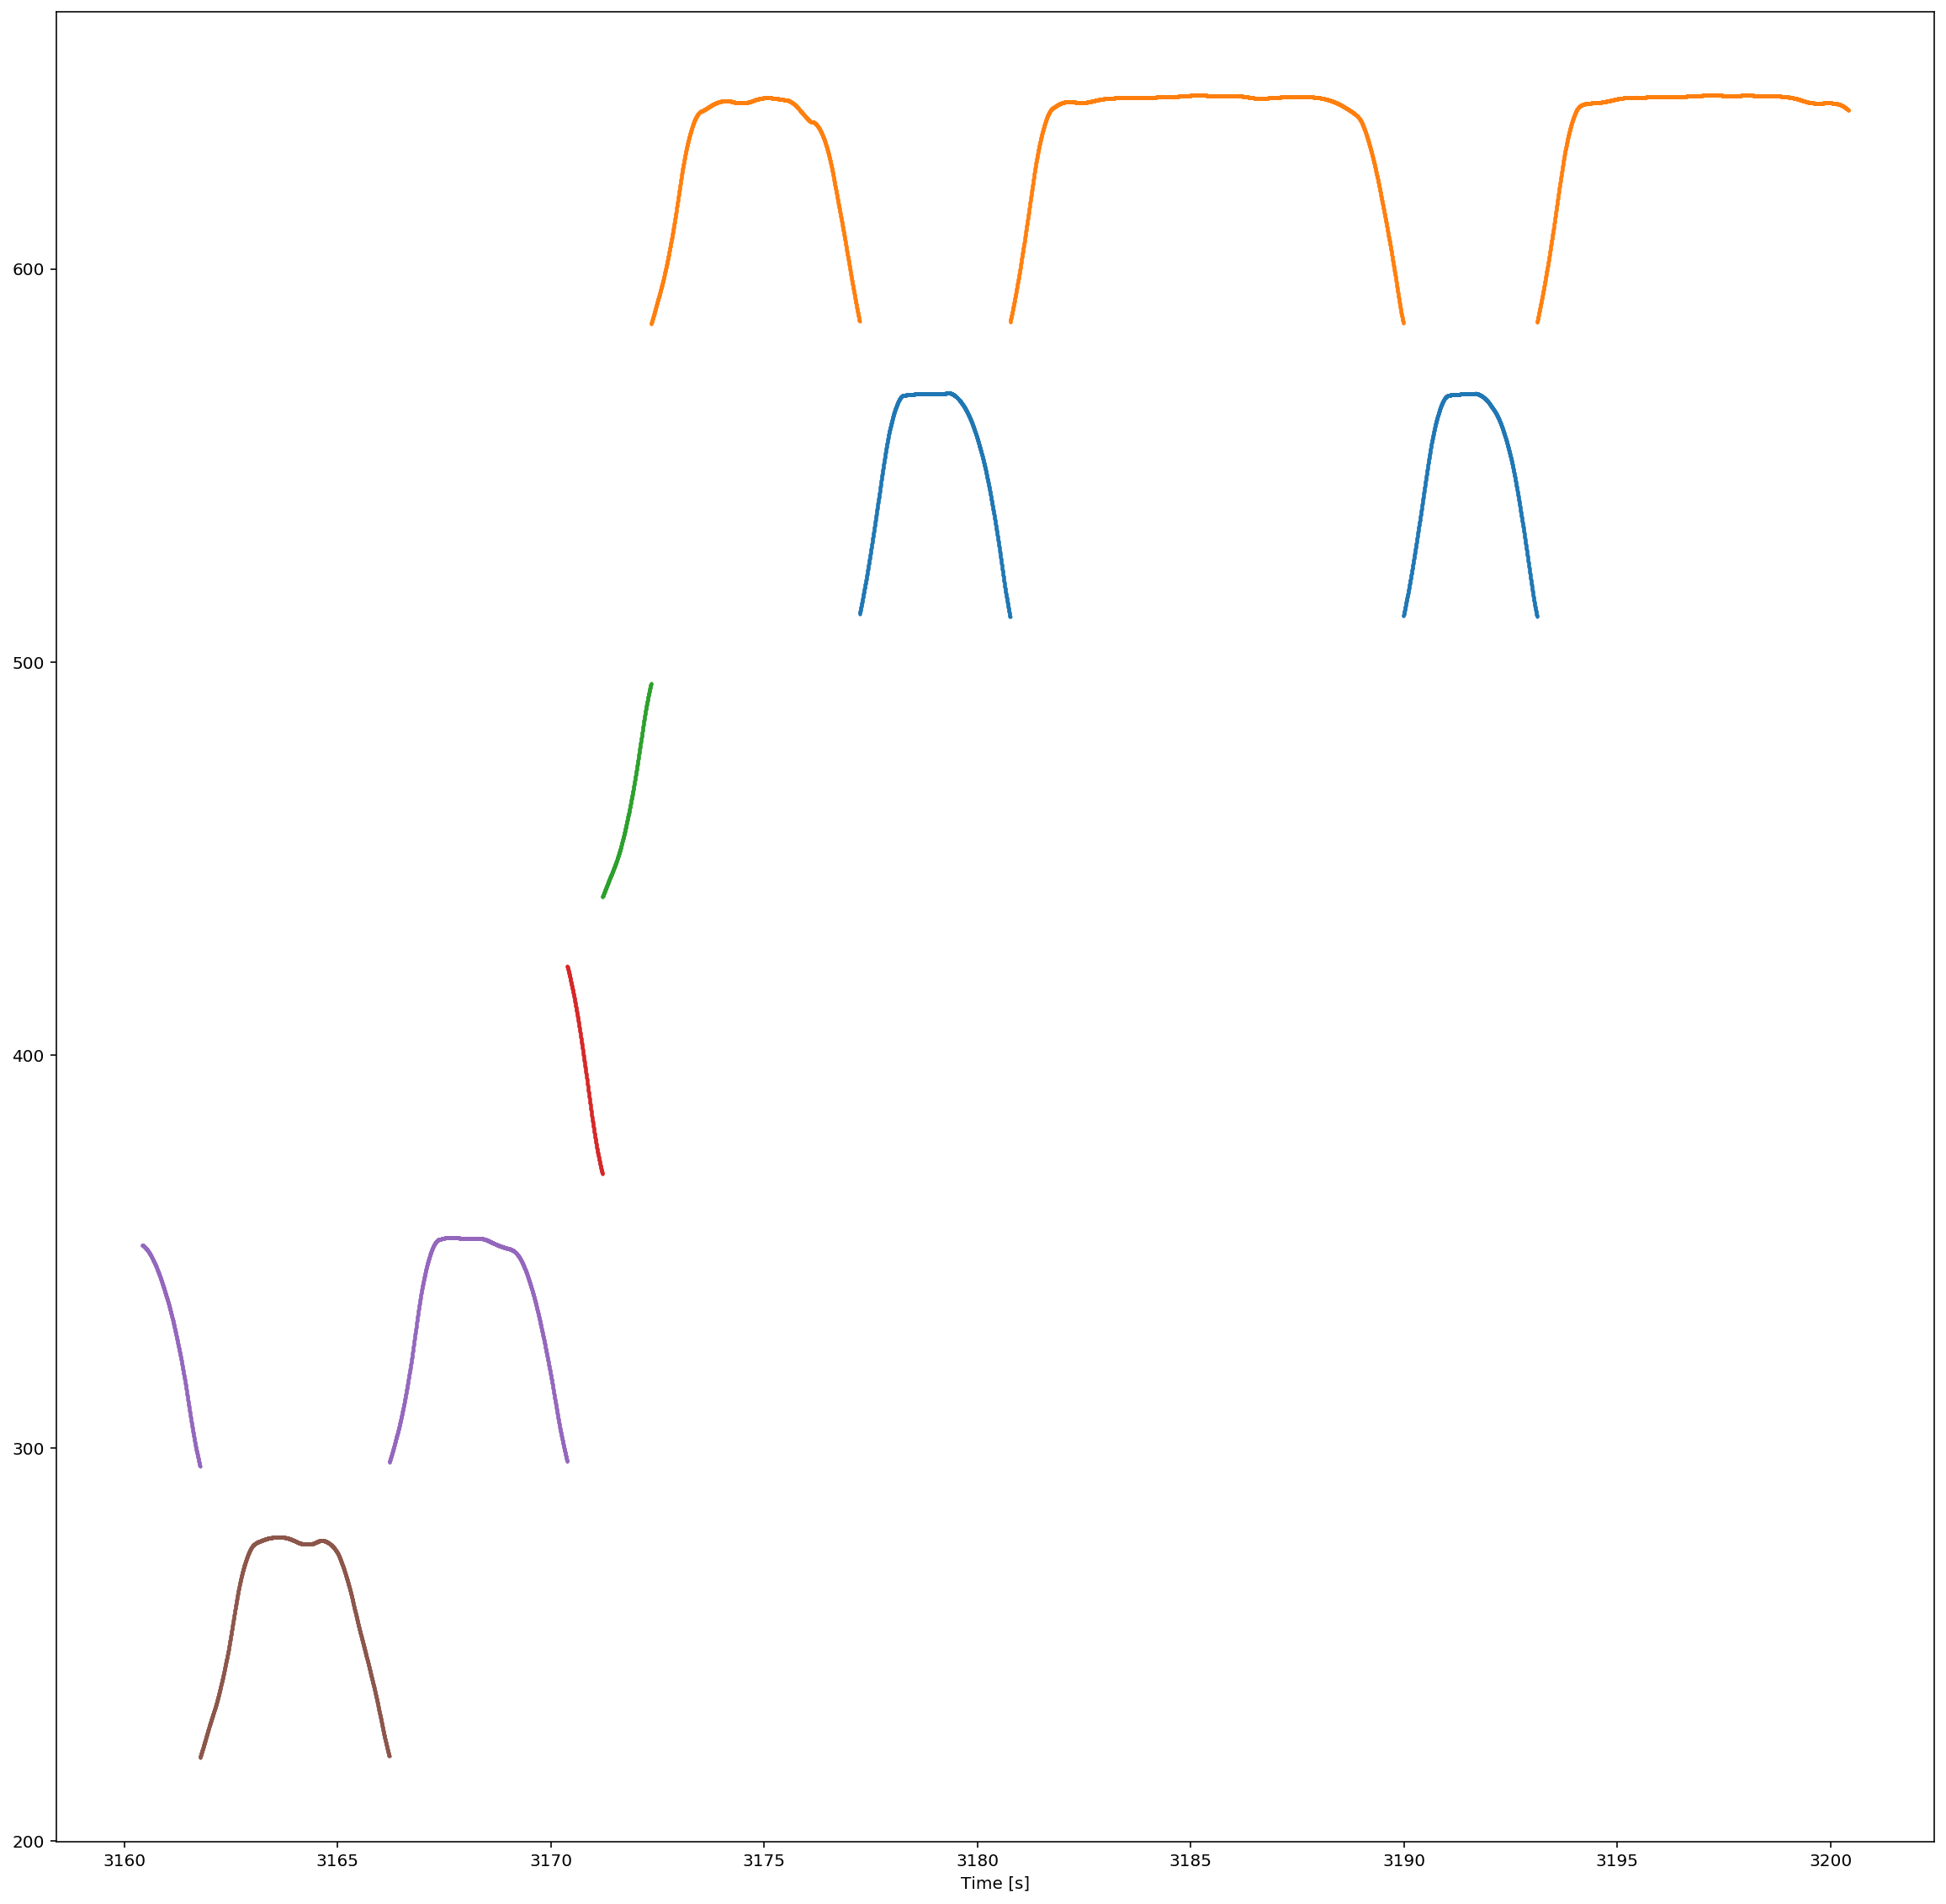

In [124]:
#find some trajectories!
fig, ax = plt.subplots(figsize=(20, 20))

for edge_label, df in p[400000:420000].groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
#ax.set_ylim([-5,200])
#ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');
#plt.hlines(570, 2415,2435)
#plt.hlines(585, 2415,2435)

# plt.hlines(495, 2415,2435)
# plt.hlines(510, 2415,2435)

# plt.hlines(135, 2415,2460)
# plt.hlines(150, 2415,2460)

# plt.hlines(60, 2415,2460)
# plt.hlines(75, 2415,2460)

# plt.hlines(0, 2415,2460)

In [111]:
p.index

TimedeltaIndex(['00:39:20.420276', '00:39:20.422276', '00:39:20.424276',
                '00:39:20.426276', '00:39:20.428276', '00:39:20.430276',
                '00:39:20.432276', '00:39:20.434276', '00:39:20.436276',
                '00:39:20.438276',
                ...
                '01:01:11.644276', '01:01:11.646276', '01:01:11.648276',
                '01:01:11.650276', '01:01:11.652276', '01:01:11.654276',
                '01:01:11.656276', '01:01:11.658276', '01:01:11.660276',
                '01:01:11.662276'],
               dtype='timedelta64[ns]', name='time', length=655622, freq='2L')